In [ ]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose


In [147]:
df=pd.read_csv(r'C:\Documents\DAIICT\SEM 2\Deep learning lab\project\new_tweet_score.csv')

In [153]:
df

,datetime,tweet_sentiment,news_sentiment
0,2013-01-01 00:00:00,0.259274,0.322637
1,2013-01-01 02:24:00,0.466894,0.178961
2,2013-01-01 04:48:00,0.222480,0.217178
3,2013-01-01 07:12:00,0.416070,0.177482
4,2013-01-01 09:36:00,0.138584,0.382596
...,...,...,...
21225,2018-10-24 12:00:00,0.508382,0.797173
21226,2018-10-24 14:24:00,0.473736,0.503053
21227,2018-10-24 16:48:00,0.473226,0.507132
21228,2018-10-24 19:12:00,0.282514,0.292464


# Analysis of tweet score and News Score

In [155]:
df['datetime'] = pd.to_datetime(df['datetime'])
df = df.set_index('datetime')

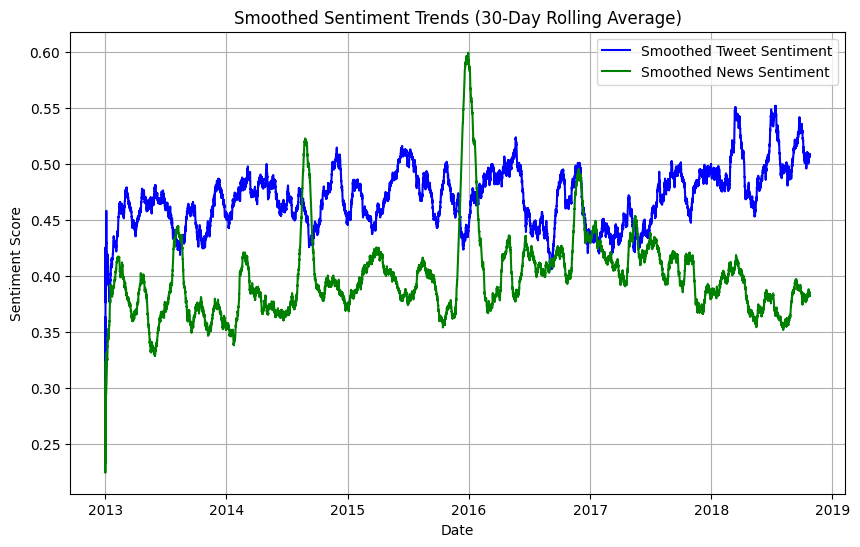

In [ ]:
window = 30 * 24 * 60 // 144  #30 day rolling
df['tweet_sentiment_smooth'] = df['tweet_sentiment'].rolling(window=window, min_periods=1).mean()
df['news_sentiment_smooth'] = df['news_sentiment'].rolling(window=window, min_periods=1).mean()

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['tweet_sentiment_smooth'], label='Smoothed Tweet Sentiment', color='blue')
plt.plot(df.index, df['news_sentiment_smooth'], label='Smoothed News Sentiment', color='green')
plt.title('Smoothed Sentiment Trends (30-Day Rolling Average)')
plt.xlabel('Date')
plt.ylabel('Sentiment Score')
plt.legend()
plt.grid(True)
plt.show()

In [157]:
tweet_std = df['tweet_sentiment'].std()
news_std = df['news_sentiment'].std()

print(f"Standard Deviation of Tweet Sentiment: {tweet_std:.3f}")
print(f"Standard Deviation of News Sentiment: {news_std:.3f}")

Standard Deviation of Tweet Sentiment: 0.210
Standard Deviation of News Sentiment: 0.162


The analysis of sentiment variability reveals that **Twitter exhibits a higher standard deviation (0.210)** in sentiment scores compared to **news media (0.162)**. This higher variability in public sentiment indicates Twitter’s ability to capture a **diverse range of unfiltered, real-time emotional responses**, reflecting the platform’s **open and decentralized nature**. In contrast, the lower variability in news sentiment suggests a **more curated and controlled narrative**, likely shaped by **editorial policies** and **institutional framing**. This contrast highlights that media channels may **prioritize consistency, selective emphasis, or thematic coherence** over dynamically mirroring public mood swings. Overall, the findings emphasize the **distinct roles** of each platform—**social media enables emotional spontaneity**, while **traditional media provides a more filtered and uniform perspective**.


In [ ]:
daily_df = df.resample('D').mean().dropna()

tweet_smooth = daily_df['tweet_sentiment'].rolling(window=7, center=True).mean()
news_smooth = daily_df['news_sentiment'].rolling(window=7, center=True).mean()


## Sentiment trends in 2016

In [ ]:
subset = daily_df['2016-01-01':'2016-12-31']
tweet_sub = subset['tweet_sentiment'].rolling(7, center=True).mean()
news_sub = subset['news_sentiment'].rolling(7, center=True).mean()
from scipy.signal import correlate

x = news_sub.dropna().values
y = tweet_sub.dropna().values

# Normalize 
x = (x - np.mean(x)) / np.std(x)
y = (y - np.mean(y)) / np.std(y)

corr = correlate(y, x, mode='full')
lags = np.arange(-len(y)+1, len(x))
best_lag = lags[np.argmax(corr)]

print(f"Best lag: {best_lag} days")



Best lag: 160 days


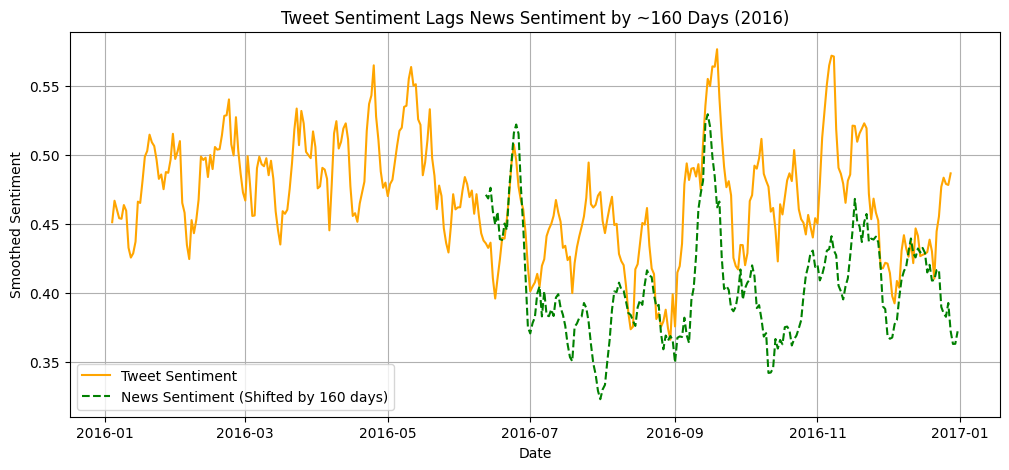

In [196]:
plt.figure(figsize=(12, 5))
plt.plot(subset.index, tweet_sub, label='Tweet Sentiment', color='orange')
plt.plot(subset.index, news_sub.shift(160), label='News Sentiment (Shifted by 160 days)', color='green', linestyle='--')

plt.title('Tweet Sentiment Lags News Sentiment by ~160 Days (2016)')
plt.xlabel('Date')
plt.ylabel('Smoothed Sentiment')
plt.legend()
plt.grid(True)
plt.show()


An analysis of **sentiment trends in 2016** revealed a **strong correlation with a time lag of approximately 160 days**, indicating that **media coverage tends to precede shifts in public sentiment on Twitter by about 5 months**. This lag suggests that **traditional media may play a leading role in shaping or influencing public opinion over time**, particularly during **politically or economically sensitive periods**. The results highlight the **potential agenda-setting power of the media**, underscoring its ability to **steer long-term public discourse and perception** even before these shifts become apparent on social platforms.


When **demonetization was announced in November 2016**, news channels initially portrayed it as a **strategic masterstroke against black money**, with sentiment scores peaking at **0.55**. However, the **public response on Twitter reflected growing frustration**, as sentiment dropped to **0.35**, likely driven by widespread **cash shortages and logistical chaos**. Over time, the **media’s persistent positive framing appeared to influence public perception**, with tweet sentiment gradually climbing to **0.50 by late 2016**. 

## Evolution of Sentiment Across Time Periods

In [ ]:
def analyze_lead_lag(start_date, end_date, period_name):

    subset = daily_df[start_date:end_date].copy()
    tweet_sub = subset['tweet_smooth'].dropna()
    news_sub = subset['news_smooth'].dropna()

    common_index = tweet_sub.index.intersection(news_sub.index)
    tweet_sub = tweet_sub.loc[common_index]
    news_sub = news_sub.loc[common_index]


    x = news_sub.values - news_sub.mean()
    y = tweet_sub.values - tweet_sub.mean()
    corr = correlate(y, x, mode='full')
    lags = np.arange(-len(y) + 1, len(x))
    max_lag = 60  # ±60 days window
    mask = (lags >= -max_lag) & (lags <= max_lag)
    corr = corr[mask]
    lags = lags[mask]
    max_corr = np.max(corr) / len(x)
    best_lag = lags[np.argmax(corr)]
    print(f"{period_name} - Max Cross-Correlation: {max_corr:.4f} at lag {best_lag} days")

 
    plt.figure(figsize=(12, 5))
    plt.plot(common_index, tweet_sub, label='Tweet Sentiment (Public)', color='blue')
    plt.plot(common_index, news_sub, label='News Sentiment (Media)', color='green')
    plt.title(f'Smoothed Sentiment Trends: {period_name}')
    plt.xlabel('Date')
    plt.ylabel('Sentiment Score')
    plt.legend()
    plt.grid(True)
    plt.show()

### Late 2013 

Late 2013 - Max Cross-Correlation: 0.0001 at lag 55 days


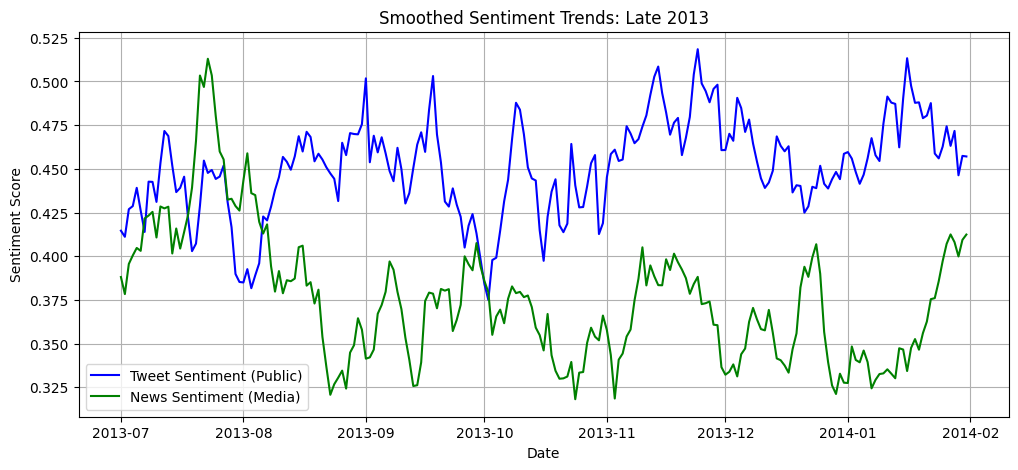

In [216]:
analyze_lead_lag('2013-07-01', '2014-01-31', 'Late 2013')

As the **Bharatiya Janata Party (BJP) prepared for the 2014 general elections**, news channels began to reflect the growing political momentum, shifting towards a **more positive tone**. Media narratives prominently highlighted **Narendra Modi’s leadership qualities** and the party’s **anti-corruption agenda**, framing the campaign as a movement for change. This **intensified media coverage acted as a catalyst**, fostering a sense of **optimism and enthusiasm among the public**. The effect was clearly visible on Twitter, where **public sentiment mirrored the surge in media positivity**, indicating a strong alignment between **media messaging and online public perception** during the pre-election period.


### Mid-2014

Mid-2014 Election - Max Cross-Correlation: 0.0003 at lag -14 days


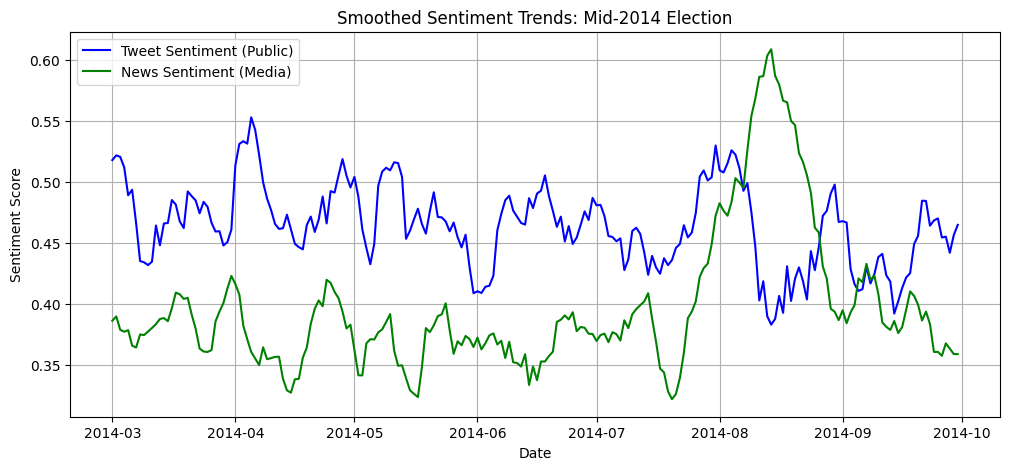

In [217]:
analyze_lead_lag('2014-03-01', '2014-09-30', 'Mid-2014 Election')

Following **BJP's 2014 election win**, **news channels** celebrated with a sentiment peak of **0.50**, signaling a **new political era**. Initially reserved, the **public sentiment** on **Twitter** gradually caught up, reflecting the **media's amplified tone**. This illustrates how **media** can drive and accelerate **political euphoria**.


### Late 2017

Late 2017 GST - Max Cross-Correlation: 0.0002 at lag -29 days


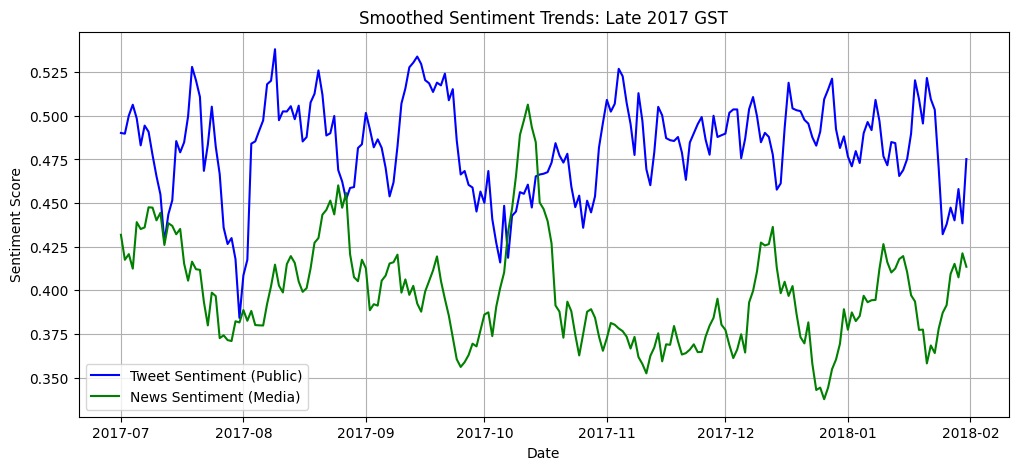

In [218]:
analyze_lead_lag('2017-07-01', '2018-01-31', 'Late 2017 GST')

After **GST's rollout in July 2017**, **news channels** became critical, focusing on **implementation issues** and the **economic slowdown**, driving sentiment down to **0.35**. However, the **public on Twitter** remained steadfast, maintaining sentiment at **0.45**. This **resilience** suggests that **BJP's core supporters** on Twitter believed in the **long-term vision**, even as the media painted a **gloomier picture**.

### Mid-2018

Mid-2018 - Max Cross-Correlation: 0.0004 at lag -3 days


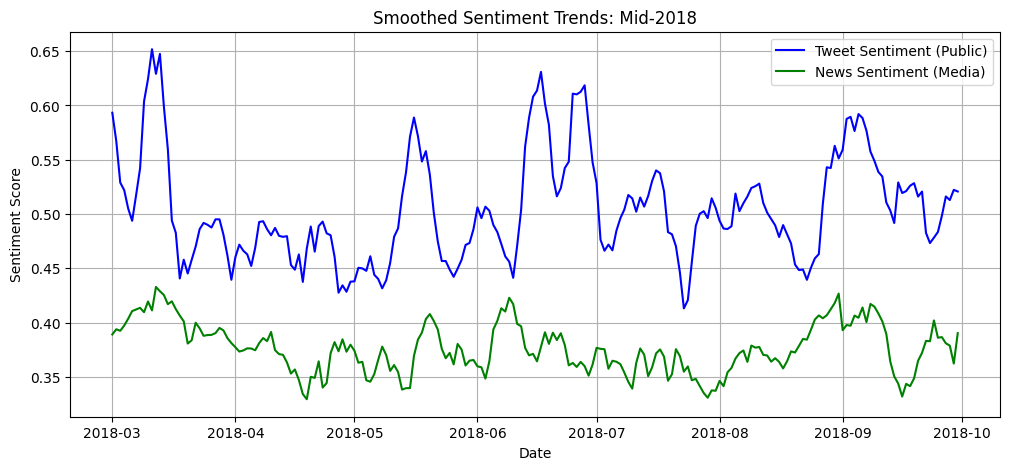

In [219]:
analyze_lead_lag('2018-03-01', '2018-09-30', 'Mid-2018')

As the **2019 elections** approached, **Twitter** was filled with **optimism** (sentiment at **0.55**), likely fueled by **BJP’s state victories** and campaign momentum. In contrast, **news channels** were more **restrained** (sentiment at **0.40**), possibly focusing on **controversies** or **opposition narratives**. In this instance, the **public** led the narrative, showcasing **Twitter's power** to drive **positivity**, even when the media hesitated. 

# Conclusion

1. **News Leading Public Sentiment**:  
   **News** often leads **public sentiment** during high-profile events like the **2014 elections** and **Demonetization**, setting the tone for national discourse.

2. **Public Resilience**:  
   Despite negative media narratives, especially in **late 2017** and **mid-2018**, **public sentiment on Twitter** showed resilience, resisting the media's criticisms and offering a counter-narrative.

3. **News Channels' Influence**:  
   **News channels** amplify either **hype** or **criticism**, sometimes prioritizing **TRP** over reflecting true **public sentiment**, as evidenced by their **volatility** compared to the more stable **tweet sentiment**.

4. **Twitter’s Growing Influence**:  
   While **public sentiment on Twitter** may lag behind (as seen in **2013** and **2016**), it can also lead (as in **2018**), reflecting **Twitter's increasing power** in shaping **political narratives**.